In [2]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
def fetchData(startDate, endDate):
    res = requests.get("http://localhost:7001/api/report/tickets/count?startDate=" + startDate + "&endDate=" + endDate)
    res = res.json()

    result = []
    for item in res:
        # 读取前N天售票量
        i = 0
        for row in item['dayRows']:
            if i > 6:
                nItem = {
                    'date': item['date'],
                    'day': row['day']
                }   
                for index in range(5):
                    currentData = item['dayRows'][i - index - 1]
                    beforeTotal = currentData['total']
                    nItem['total'] = item['dayRows'][i]['total']
                    nItem['z' + str(index)] = beforeTotal
                result.append(nItem)
            i  = i + 1
            
    return result

In [4]:
df = fetchData('2021-03-10', '2021-03-24')
df = pd.json_normalize(df)
# 周日年卡
df['memberDay'] = df['date'].map(lambda x: 1 if datetime.strptime(x,"%Y-%m-%d").weekday() == 6 else 0)
# # 双休日
df['isWeekend'] = df['date'].map(lambda x: 1 if datetime.strptime(x,"%Y-%m-%d").weekday() >= 5 else 0)

df.head()

,date,day,total,z0,z1,z2,z3,z4,memberDay,isWeekend
0,2021-03-10,19,4,4,3,1,2,1,0,0
1,2021-03-10,18,6,4,4,3,1,2,0,0
2,2021-03-10,17,4,6,4,4,3,1,0,0
3,2021-03-10,16,2,4,6,4,4,3,0,0
4,2021-03-10,15,5,2,4,6,4,4,0,0


In [5]:
# 数据清洗
dataset = df[df['day'] < 5]
dataset = dataset[['total', 'day', 'z0', 'z1', 'z2', 'z3', 'memberDay', 'isWeekend']]
dataset['memberDay'] = dataset['memberDay']*1.0
dataset['isWeekend'] = dataset['isWeekend']*1.0
dataset['day'] = dataset['day']*1.0

dataset.head(20)

,total,day,z0,z1,z2,z3,memberDay,isWeekend
15,99,4.0,59,36,32,27,0.0,0.0
16,127,3.0,99,59,36,32,0.0,0.0
17,219,2.0,127,99,59,36,0.0,0.0
18,340,1.0,219,127,99,59,0.0,0.0
19,625,0.0,340,219,127,99,0.0,0.0
37,92,4.0,65,42,22,21,0.0,0.0
38,103,3.0,92,65,42,22,0.0,0.0
39,139,2.0,103,92,65,42,0.0,0.0
40,246,1.0,139,103,92,65,0.0,0.0
41,375,0.0,246,139,103,92,0.0,0.0


In [6]:
# 拆分训练数据集和测试数据集
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [7]:
# 特征提取
train_stats = train_dataset.describe()
train_stats.pop("total")
train_stats = train_stats.transpose()

train_stats

,count,mean,std,min,25%,50%,75%,max
day,60.0,2.133333,1.443474,0.0,1.00,2.0,3.25,4.0
z0,60.0,327.000000,268.285012,59.0,131.25,249.5,418.00,1432.0
z1,60.0,229.500000,188.499022,36.0,98.50,165.0,304.50,965.0
z2,60.0,164.066667,134.526145,22.0,77.50,117.0,200.50,678.0
z3,60.0,116.183333,89.559656,21.0,58.25,89.0,159.00,427.0
memberDay,60.0,0.100000,0.302532,0.0,0.00,0.0,0.00,1.0
isWeekend,60.0,0.250000,0.436667,0.0,0.00,0.0,0.25,1.0


In [8]:
# 数据规范化

# def norm(x):
#   return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)

normed_train_data = train_dataset
normed_test_data = test_dataset

In [9]:
train_stats = train_dataset.describe()
train_stats.pop("total")
train_stats = train_stats.transpose()

train_stats

# 从标签中分离特征
train_labels = train_dataset.pop('total')
test_labels = test_dataset.pop('total')

In [10]:
# 编译模型
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [11]:
model = build_model()
model.summary()

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


array([[-160.77817 ],
       [ -97.52389 ],
       [-103.39192 ],
       [-207.5422  ],
       [ -98.61271 ],
       [ -56.279583],
       [ -83.44685 ],
       [-302.3086  ],
       [ -77.5778  ],
       [ -33.207882]], dtype=float32)

In [12]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [13]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,1696.497559,28.970896,1696.497559,3335.953125,46.194031,3335.953125,995
996,1635.792969,31.361923,1635.792969,3654.900391,44.881134,3654.900391,996
997,1188.699585,25.322853,1188.699585,3898.353516,45.366596,3898.353516,997
998,1181.074585,25.368835,1181.074585,3473.978760,45.041843,3473.978760,998
999,1421.312866,27.475004,1421.312866,7176.314941,61.964279,7176.314941,999


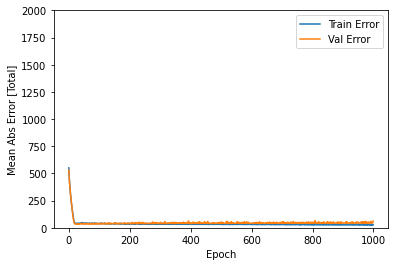

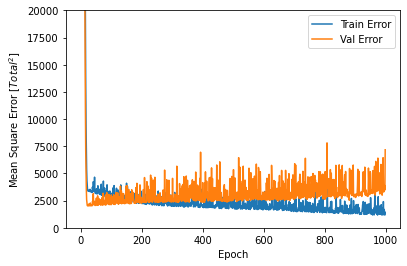

In [14]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Total]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,2000])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Total^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20000])
  plt.legend()
  plt.show()


plot_history(history)


.........................................................................................

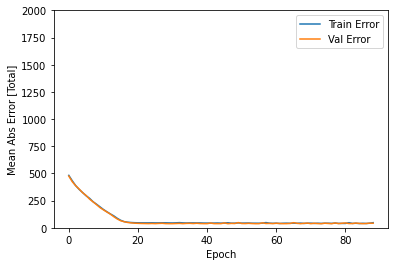

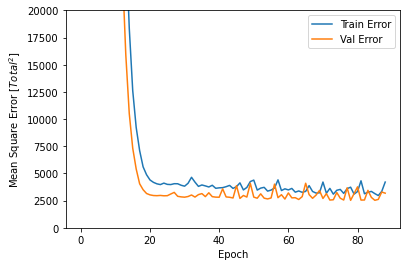

In [15]:
model = build_model()

# patience 值用来检查改进 epochs 的数量
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [16]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

1/1 - 0s - loss: 3051.2607 - mae: 47.1446 - mse: 3051.2607
Testing set Mean Abs Error: 47.14 MPG


,day,z0,z1,z2,z3,memberDay,isWeekend
41,0.0,246,139,103,92,0.0,0.0
62,2.0,303,211,159,114,0.0,0.0
89,2.0,678,427,267,197,0.0,1.0
113,3.0,257,152,94,79,1.0,1.0
115,1.0,565,415,257,152,1.0,1.0
116,0.0,861,565,415,257,1.0,1.0
190,3.0,97,76,49,37,0.0,0.0
193,0.0,208,126,121,97,0.0,0.0
222,0.0,294,185,135,106,0.0,0.0
249,3.0,172,126,91,72,0.0,0.0


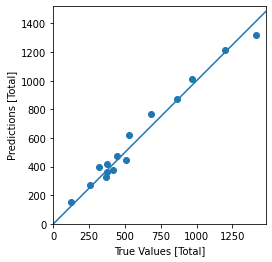

In [17]:
# 做预测
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Total]')
plt.ylabel('Predictions [Total]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-10000, 10000], [-10000, 10000])

normed_test_data

In [20]:
model.save('../src/model/tickets.h5')

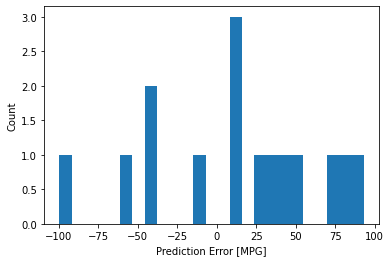

In [19]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")